In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), mismatched flags (16))


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [49]:
args = Args(batchsize = 128, epochs = 10, use_cuda = true)

Args(0.001, 128, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

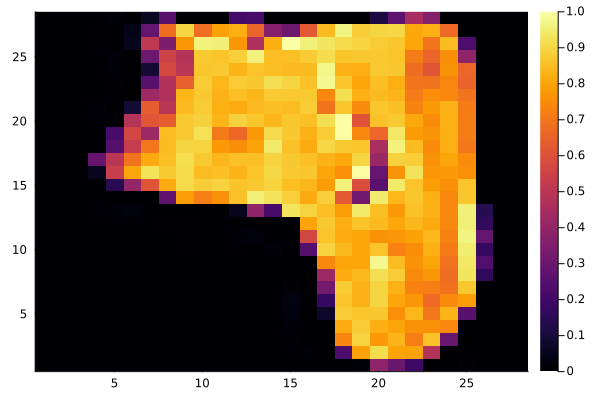

In [15]:
heatmap(x0[:,:,1])

# Test conventional network

In [42]:
model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            Conv((16, 16), 1 => 3, relu),
            Conv((8, 8), 3 => 1, relu),
            FlattenLayer(),
            Dense(36 => 128, relu),
            Dense(128 => 10),
            softmax)

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#39),
    layer_3 = Conv((16, 16), 1 => 3, relu),  # 771 parameters
    layer_4 = Conv((8, 8), 3 => 1, relu),  # 193 parameters
    layer_5 = FlattenLayer{Nothing}(nothing),
    layer_6 = Dense(36 => 128, relu),   # 4_736 parameters
    layer_7 = Dense(128 => 10),         # 1_290 parameters
    layer_8 = WrappedFunction(softmax),
)         # Total: 8_558 parameters,
          #        plus 0 states.

In [43]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.027954446 -0.1617307 … 0.016242968 0.14963324; 0.13287999 -0.012666304 … 0.075101405 -0.008363487; … ; -0.08187634 -0.09269406 … 0.0061865277 0.013008435; -0.043899752 0.052714854 … -0.17949729 0.14304845;;;; -0.024908273 0.031509586 … 0.0044658813 0.057057727; -0.07205882 0.003650815 … -0.15006648 0.06562398; … ; 0.17004335 0.14767104 … 0.18636338 -0.054633513; 0.079783104 -0.08834659 … -0.14960322 0.15888822;;;; -0.03399928 -0.20543711 … 0.0294896 -0.12279989; -0.15870962 -0.0088076955 … -0.10662859 -0.12584813; … ; -0.13247463 -0.13006665 … 0.1938359 0.08898964; 0.08483048 0.19980569 … 0.051674522 0.068520375], bias = Float32[-0.047708765, -0.021063387, -0.049803995]), layer_4 = (weight = Float32[0.15114218 0.019617587 

In [44]:
yp, _ = model(x0, ps, st);

In [45]:
yp |> size

(10, 128)

In [46]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [47]:
loss_function(x0, y0, model, ps, st)

9.498552f0

In [50]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[9.498553f0, 7.9316044f0, 7.0406747f0, 6.2276f0, 4.8801527f0, 4.331775f0, 3.6640983f0, 3.7957478f0, 3.1880972f0, 3.0978448f0  …  0.3736422f0, 0.35444552f0, 0.27729172f0, 0.4436319f0, 0.42786843f0, 0.4158905f0, 0.41042462f0, 0.4456694f0, 0.30675453f0, 0.36461115f0], (layer_1 = (bias = Float32[0.16879417 0.047069523 … 0.40985367 -0.093897976; -0.21321698 0.013799127 … 0.06122239 -0.18150581; … ; 0.015796123 0.064588696 … -0.35536155 0.13324626; 0.004913077 -0.24131674 … 0.0075063556 -0.0926447;;;], scale = Float32[0.82577085 0.95328915 … 0.59752584 1.0964141; 1.2050118 0.98963386 … 0.96394026 1.1735797; … ; 0.9846601 0.94516575 … 1.3110563 0.8300549; 1.0068389 1.2555723 … 0.9600243 1.0945408;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.03131204 -0.04785028 … -0.047813587 0.060458105; 0.06888987 -0.07089678 … 0.021058917 -0.010615111; … ; -0.004175516 -0.09817701 … -0.018682621 -0.015141373; -0.019062424 0.059016928 … -0.19140631 0.056328893;;;; 0.28031442 0.17374364 …

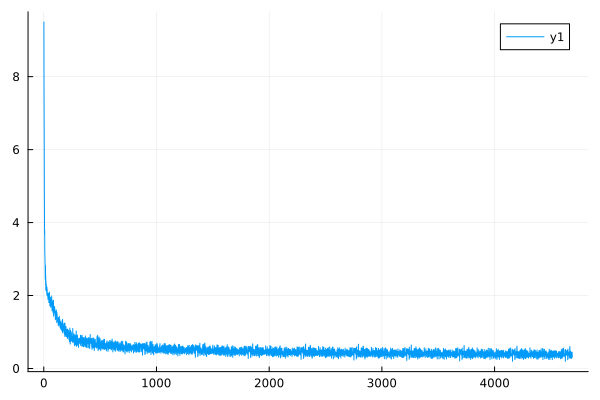

In [51]:
plot(losses)

In [52]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [53]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [54]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.1003

In [55]:
test(model, test_loader, pst, stt)

0.8425

# Test Phasor network

In [68]:
import .PhasorNetworks: default_bias

In [56]:
p_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => 128, soft_angle),
            PhasorDense(128 => 10, soft_angle),
            )

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#59),
    layer_3 = WrappedFunction(#60),
    layer_4 = WrappedFunction(#61),
    layer_5 = PhasorConv(
        conv = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),  # 6 parameters
    ),
    layer_6 = PhasorConv(
        conv = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),  # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        dense = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_9 = PhasorDense(
        dense = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)         # Total: 8_700 parameters,
          #        plus 0 states.

In [57]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (conv = (weight = Float32[-0.009854739 0.0038908052 … 0.027410084 -0.042598046; -0.070673175 0.104087085 … 0.049341556 0.08563622; … ; -0.06473391 0.011930782 … -0.06712644 -0.09788201; 0.06555001 0.02655389 … 0.032844663 -0.06681369;;;; 0.07751807 -0.08933787 … -0.077698514 0.026187355; -0.022558916 -0.016725788 … -0.05284896 0.02503194; … ; 0.10457837 0.051915325 … -0.09805432 -0.019708611; 0.0033002049 0.04073822 … -0.05697163 -0.09414006;;;; -0.089306 0.04426323 … -0.03757296 0.091783725; -0.095490396 -0.09812156 … 0.10808913 0.018936118; … ; 0.026458163 0.03929309 … -0.07876754 0.07608826; -0.027097194 0.09594075 … 0.097982176 -0.03557449],), bias = (bias_real = Float32[1.0;;; 1.0;;; 1.0], b

In [58]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.30128777 -0.3619314 … -0.2143705 0.017268002; 0.43331742 0.61217266 … 0.31124982 0.4899945; … ; 0.017067928 -0.03358814 … -0.07262404 -0.022021277; -0.022352366 0.046107218 … -0.08664602 0.102870986], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (conv = NamedTuple(), bias = NamedTuple()), layer_6 = (conv = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = (dense = NamedTuple(), bias = NamedTuple()), layer_9 = (dense = NamedTuple(), bias = NamedTuple())))

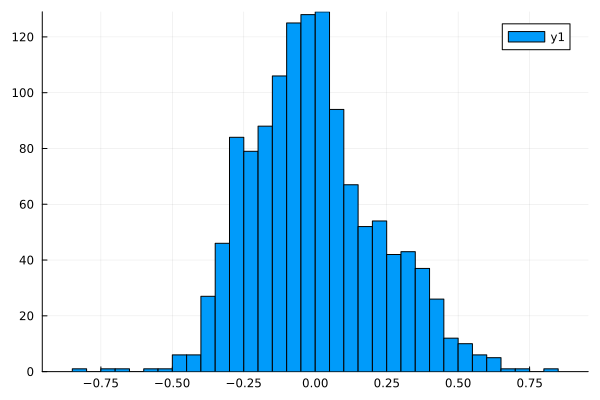

In [59]:
histogram(cdev(vec(yp0)))

In [60]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = quadrature_loss(y_pred, y_onehot) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [61]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

0.2985279f0

In [62]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CUDA GPU


(Any[0.2985279f0, 0.138981f0, 0.11774896f0, 0.110559806f0, 0.105119064f0, 0.102010906f0, 0.09892672f0, 0.09977052f0, 0.09970449f0, 0.09612951f0  …  0.031070689f0, 0.026524458f0, 0.019305805f0, 0.034975097f0, 0.028832065f0, 0.027038937f0, 0.028442869f0, 0.027461508f0, 0.02279594f0, 0.025698647f0], (layer_1 = (bias = Float32[0.40114442 -0.24786495 … 0.28768423 -0.14292118; -0.2780916 0.18105483 … -0.26500422 0.07712689; … ; 0.3626556 0.3210869 … -0.05294495 -0.3907833; -0.56552565 -0.11082051 … 0.35173658 -0.011079768;;;], scale = Float32[0.59696555 1.2542009 … 0.7204243 1.154662; 1.2773906 0.81130093 … 1.2927147 0.934225; … ; 0.63139963 0.6785937 … 1.0869966 1.3603096; 1.5559987 1.1055102 … 0.62011963 1.0130451;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (conv = (weight = Float32[0.13923216 -0.013217438 … 0.02119293 -0.13868444; -0.04810053 0.10584916 … -0.01866303 -0.012339755; … ; -0.03576122 0.091391295 … -0.10767537 0.02097061; -0.04489495

In [63]:
ps_train_f.layer_5.bias

(bias_real = Float32[1.4059283;;; 1.3621695;;; 1.4943793], bias_imag = Float32[0.27326682;;; 0.44706008;;; 0.32955834])

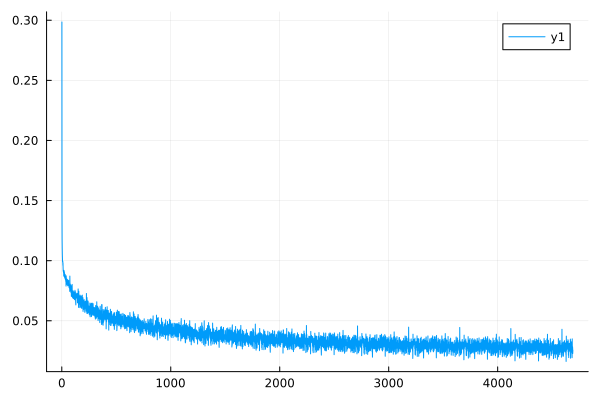

In [64]:
#plot(losses)
plot(losses_f)

In [65]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_quadrature(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [66]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.8255

# Test spiking behavior

In [69]:
spk_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => 128, soft_angle),
            PhasorDense(128 => 10, soft_angle),
            )
            

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#67),
    layer_3 = WrappedFunction(#68),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorConv(
        conv = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),  # 6 parameters
    ),
    layer_6 = PhasorConv(
        conv = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),  # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        dense = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_9 = PhasorDense(
        dense = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)     

In [70]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (conv = (weight = Float32[-0.10418762 -0.07921882 … -0.02758355 -0.101126105; -0.036764827 -0.07909273 … -0.003805182 -0.008638979; … ; -0.0523939 -0.06744159 … -0.047663253 -0.07518775; -0.069391474 -0.04738358 … -0.058090575 -0.03783636;;;; -0.09935624 0.005881394 … -0.09686394 0.10002758; -0.026586939 -0.06894098 … 0.042650387 0.00035179732; … ; -0.075348325 0.04283877 … 0.07490573 -0.10156589; 0.103475176 -0.07863577 … -0.038987327 -0.06475672;;;; -0.07121319 -0.01800282 … -0.016507115 -0.086084366; 0.09531467 -0.0048177815 … -0.057257324 -0.07887037; … ; -0.022041706 -0.038457703 … -0.034113396 -0.02040898; -0.095595 0.045745615 … -0.0061293724 0.07209018],), bias = (bias_real = Float32[1.0;

In [73]:
typeof(x0)

Array{Float32, 3}

In [81]:
ps0t.layer_5.conv

(weight = Float32[-0.10418762 -0.07921882 … -0.02758355 -0.101126105; -0.036764827 -0.07909273 … -0.003805182 -0.008638979; … ; -0.0523939 -0.06744159 … -0.047663253 -0.07518775; -0.069391474 -0.04738358 … -0.058090575 -0.03783636;;;; -0.09935624 0.005881394 … -0.09686394 0.10002758; -0.026586939 -0.06894098 … 0.042650387 0.00035179732; … ; -0.075348325 0.04283877 … 0.07490573 -0.10156589; 0.103475176 -0.07863577 … -0.038987327 -0.06475672;;;; -0.07121319 -0.01800282 … -0.016507115 -0.086084366; 0.09531467 -0.0048177815 … -0.057257324 -0.07887037; … ; -0.022041706 -0.038457703 … -0.034113396 -0.02040898; -0.095595 0.045745615 … -0.0061293724 0.07209018],)

In [82]:
ps0t.layer_5.bias

(bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])

In [71]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

┌ Warning: Mixed Precision Inputs received for GPU convolution [weight: Float32] and [x: Float64]. Promoting to Float64.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/1B1qw/src/utils.jl:224


LoadError: MethodError: no method matching (::FlattenLayer{Nothing})(::SpikingCall, ::@NamedTuple{}, ::@NamedTuple{})
The object of type `FlattenLayer{Nothing}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

[0mClosest candidates are:
[0m  (::FlattenLayer{Nothing})([91m::AbstractArray{T, N}[39m, ::Any, ::NamedTuple) where {T, N}
[0m[90m   @[39m [36mLux[39m [90m~/.julia/packages/Lux/lRugP/src/layers/[39m[90m[4mbasic.jl:163[24m[39m
[0m  (::FlattenLayer)([91m::AbstractArray{T, N}[39m, ::Any, ::NamedTuple) where {T, N}
[0m[90m   @[39m [36mLux[39m [90m~/.julia/packages/Lux/lRugP/src/layers/[39m[90m[4mbasic.jl:167[24m[39m


In [ ]:
ys0.train

SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[1.9996275, 2.0000722, 2.0001302, 2.0003524, 2.000451, 2.0001328, 2.0002174, 2.0000694, 2.000158, 1.9999394  …  20.501926, 21.181822, 21.018099, 21.495605, 21.018276, 21.491499, 20.641499, 21.081219, 20.657145, 21.063665], (10, 128), 1280, 0.5f0)

In [ ]:
ys0.t_span

(0.0f0, 20.0f0)

In [ ]:
y_spk_f, st_spk_f = spk_model(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(1, 2), CartesianIndex(2, 2), CartesianIndex(1, 3), CartesianIndex(2, 3), CartesianIndex(1, 4), CartesianIndex(2, 4), CartesianIndex(1, 5), CartesianIndex(2, 5)  …  CartesianIndex(1, 124), CartesianIndex(2, 124), CartesianIndex(1, 125), CartesianIndex(2, 125), CartesianIndex(1, 126), CartesianIndex(2, 126), CartesianIndex(1, 127), CartesianIndex(2, 127), CartesianIndex(1, 128), CartesianIndex(2, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  247, 248, 249, 250, 251, 252, 253, 254, 255, 256], Float32[2.026862, 2.0111399, 2.026862, 2.0111399, 2.0268276, 2.0111437, 2.026862, 2.0111399, 2.026862, 2.0111399  …  20.987972, 21.484526, 21.482346, 21.489006, 21.002304, 21.252728, 21.486706, 21.0917, 21.016745, 21.124039], (2, 128), 256, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTupl

In [ ]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    acc = []
    n_phases = []
    num = 0

    n_batches = length(data_loader)

    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
            y = gdev(1.0f0 .* onehotbatch(y, 0:9))
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        append!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    acc = sum(reshape(acc, :, n_batches), dims=2) ./ num
    return acc
end

fmnist_spiking_accuracy (generic function with 1 method)

In [ ]:
spk_a = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

21×1 Matrix{Float64}:
 0.1
 0.1756
 0.7414
 0.8288
 0.8527
 0.8641
 0.8702
 0.8734
 0.8752
 0.8767
 0.8786
 0.8781
 0.8783
 0.8786
 0.8801
 0.8795
 0.8808
 0.8803
 0.8806
 0.0802
 0.079

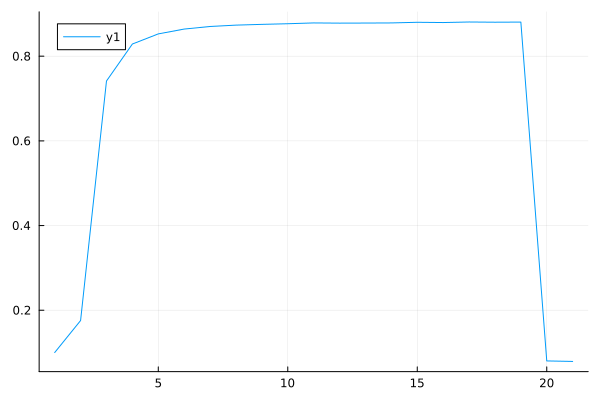

In [ ]:
plot(spk_a)